    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.

Install dependencies.

I had to downgrade Tensorflow and Keras bindings as the latest versions are incompatable with CXPlain. Tensorflow v2.7.4 requires Python 3.7&ndash;3.9

In [ ]:
!pip install -U pandas scikit-learn cxplain tensorflow==2.7.4 keras==2.7.0

# Load and preprocess dataset

Let's import the packages needed for this step:

In [3]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from pathlib import Path

The location of the University of Queensland NIDS dataset.

For now I'm only using one of the small datasets downloaded from here: https://staff.itee.uq.edu.au/marius/NIDS_datasets/

In [4]:
dsn = 'NF-BoT-IoT.csv'
dataset = Path('datasets/netflow-v1') / dsn

Reading the spreadsheet into a Pandas' dataframe, ignoring some columns.

I dropped the two IPv4 address columns as these would cause a dependency on a particular network topology.

The `Label` column shouldn't be read as it is added after the fact and not part of regular network logging.

In [5]:
df = pd.read_csv(dataset, usecols=lambda x: x not in {"IPV4_SRC_ADDR", "IPV4_DST_ADDR", "Label"})
df.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Attack
0,52670,53,17,5.212,71,126,1,1,0,4294966,Benign
1,49160,4444,6,0.000,217753000,199100,4521,4049,24,4176249,Theft
2,3456,80,17,0.000,8508021,8918372,9086,9086,0,4175916,Benign
3,80,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,Benign
4,80,80,6,7.000,8374706,0,9086,0,0,4175916,Benign


The input to the neural network is a multi dimentional NumPy array. These only support numeric data types, so we must first transform the data.

We encode the categorical data as integer indecies into an array. CXPlain requires the dependent variable (what we are trying to predict) to be a boolean value of `True`/`False`. This means we must split the `Attack` column into multiple columns for each choice. We can drop one of the categories as this can be deduced in the case where all other options are `False`.

A lot of neural networks require continuous variables to be normalised, i.e. fit to a standard normal distribution. 

In [6]:
trns = ColumnTransformer([('atk', OneHotEncoder(drop='first'), ['Attack']),
                          ('cat', OrdinalEncoder(), ['TCP_FLAGS', 'PROTOCOL'])],
                         remainder=StandardScaler())
data = trns.fit_transform(df)
#del df
trns.get_feature_names_out()

array(['atk__Attack_DDoS', 'atk__Attack_DoS',
       'atk__Attack_Reconnaissance', 'atk__Attack_Theft',
       'cat__TCP_FLAGS', 'cat__PROTOCOL', 'remainder__L4_SRC_PORT',
       'remainder__L4_DST_PORT', 'remainder__L7_PROTO',
       'remainder__IN_BYTES', 'remainder__OUT_BYTES',
       'remainder__IN_PKTS', 'remainder__OUT_PKTS',
       'remainder__FLOW_DURATION_MILLISECONDS'], dtype=object)

# Train classifier model

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

Using the Python array slicing feature, the independent (traffic) and dependent (attack type) columns are extracted.

It is good practice to seperate the data into training data for fitting the model and test data to gague the model's abillity to predict over novel data. This prevents what is called 'overfitting'.

In [8]:
X, y = data[:,4:], data[:,:4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I only perform one training iteration to speed things up. This of course means the model will be less accurate than the optimum.

In [ ]:
explained_model = MLPClassifier(verbose=True, max_iter=1, random_state=42)
explained_model.fit(X_train, y_train)

In [10]:
explained_model.score(X_test, y_test)

0.7334110981503082

70% accuracy!

# Train explanation model

In [ ]:
from tensorflow.python.keras.losses import mean_squared_error
from cxplain import MLPModelBuilder, ZeroMasking, CXPlain

import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

Here, I had to enable Tensorflow v1 compatability as the CXPlain library won't work without it.

Configuring the hyperparameters for the explainer model. These can be tuned for faster convergence but I just copied them from the docs.

Zero masking means that it will hide some part of the input to see how much that affects the result. E.g. hiding the connection duration for a DoS attack would be significant.

In [19]:
model_builder = MLPModelBuilder(num_units=24, activation='selu', p_dropout=0.2, batch_size=8, learning_rate=0.01, verbose=1, num_epochs=2)
masking_operation = ZeroMasking()
loss = mean_squared_error

Now to train the causal model. Here I have specified an additional copy to be trained as well. This is so the final output can have confidence intervals, i.e. how sure we can be that the value lies in a range. Although, this number should be increased for greater accuracy.

In [ ]:
explainer = CXPlain(explained_model, model_builder, masking_operation, loss, num_models=2)
explainer.fit(X_train, y_train)

# Single sample results

Now that we have our model, I can request it to explain the importance of each feature for all samples in the test data. The rest of the code is just to extract the data for a single sample, label it, and graph it.

In [22]:
attributions, confidence = explainer.explain(X_test, confidence_level=0.80)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from cxplain.visualisation.plot import Plot

plt.rcdefaults()

In [80]:
np.random.seed(42)
selected_index = np.random.randint(len(X_test))
selected_sample = X_test[selected_index]

importances = attributions[selected_index]*100
importances_confidence = confidence[selected_index]*100

In [81]:
atk_typ = trns.named_transformers_.atk.inverse_transform(y_test[selected_index].reshape(-1,4))[0,0]

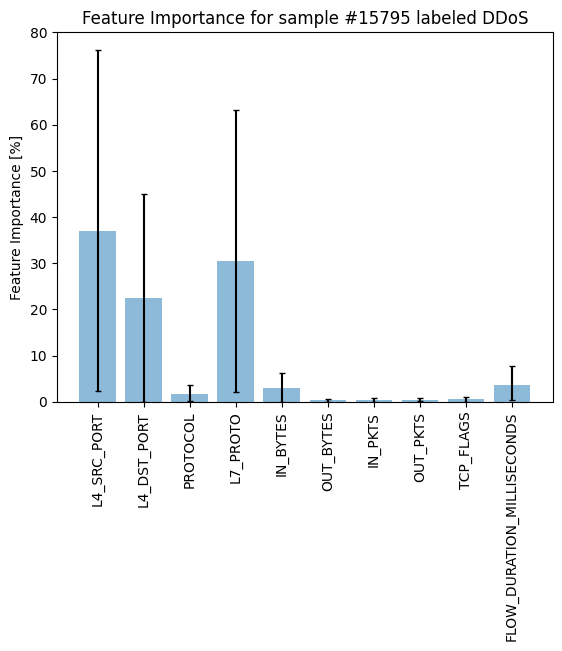

<Figure size 640x480 with 0 Axes>

In [82]:
Plot.plot_attribution_1d(selected_sample, importances, importances_confidence,
                         title=f'Feature Importance for sample #{selected_index} labeled {atk_typ}',
                         feature_names=df.columns[:-1])